# Nonlinear proximal inversion

**Author: M. Ravasi, KAUST**

Welcome to the fifth exercise of the **An introduction to proximal solvers for engineers** course!

The aim of this tutorial is to:

- Learn how to include nonlinear functionals in proximal solvers;
- Understand how to adapt PyProximal to such a scenario.

Let's first import the libraries we need in this tutorial

In [1]:
# Run this when using Colab (will install the missing libraries)
# !pip install pylops pyproximal

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pylops
import pyproximal

np.random.seed(1)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Problem statement

In this exercise, we consider the problem of finding the minimum of a nonlinear objective function under a box constraint.

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \quad f(\mathbf{m}) \quad s.t. \quad \mathbf{m}
        \in I_{Box}
$$

For the sake of simplicity, we consider the famous Rosenbrock function whose gradient is known analytically

### Functions & classes

Let’s start by defining some useful functions and classes for our problem

In [3]:
def callback(x):
    xhist.append(x)
    
def rosenbrock(x, y, a=1, b=10):
    f = (a - x)**2 + b*(y - x**2)**2
    return f

def rosenbrock_grad(x, y, a=1, b=10):
    dfx = -2*(a - x) - 2*b*(y - x**2) * 2 * x
    dfy = 2*b*(y - x**2)
    return dfx, dfy

def contour_rosenbrock(x, y):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Evaluate the function
    x, y = np.meshgrid(x, y)
    z = rosenbrock(x, y)

    # Plot the surface.
    surf = ax.contour(x, y, z, 200, cmap='gist_heat_r', vmin=-20, vmax=200,
                      antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=10)
    return fig, ax


In [4]:
class Rosebrock(pyproximal.proximal.Nonlinear):
    def setup(self, a=1, b=10, alpha=1.):
        self.a, self.b = a, b
        self.alpha = alpha
    def fun(self, x):
        return np.array(rosenbrock(x[0], x[1], a=self.a, b=self.b))
    def grad(self, x):
        return np.array(rosenbrock_grad(x[0], x[1], a=self.a, b=self.b))
    def optimize(self):
        self.solhist = []
        sol = self.x0.copy()
        for iiter in range(self.niter):
            x1, x2 = sol
            dfx1, dfx2 = self._gradprox(sol, self.tau) # _gradprox = grad(f) + grad((1/2tau)||m-v||_2^2)
            x1 -= self.alpha * dfx1
            x2 -= self.alpha * dfx2
            sol = np.array([x1, x2])
            self.solhist.append(sol)
        self.solhist = np.array(self.solhist)
        return sol

## Problem setup

Let's now set up the problem by defining our domains for plotting.

In [5]:
# Solution domain for plotting
x = np.arange(-1.5, 1.5, 0.15)
y = np.arange(-0.5, 1.5, 0.15)
nx, ny = len(x), len(y)

# Box constraint for plotting
xbound = np.arange(-1.5, 1.5, 0.01)
ybound = np.arange(-0.5, 1.5, 0.01)
X, Y = np.meshgrid(xbound, ybound, indexing='ij')
xygrid = np.vstack((X.ravel(), Y.ravel()))

## Inversion

In [6]:
# Standard nonlinear inversion
niters = 500
alpha = 0.02

xhist_nl = [(0, 0), ]
for iiter in range(niters):
    xnl, ynl = xhist_nl[-1]
    dfx, dfy = rosenbrock_grad(xnl, ynl)
    xnl -= alpha * dfx
    ynl -= alpha * dfy
    xhist_nl.append((xnl, ynl))
xhist_nl = np.array(xhist_nl)

In [ ]:
# Box constraint
lower = 0.6
upper = 1.2
indic = (xygrid > lower) & (xygrid < upper)
indic = indic[0].reshape(xbound.size, ybound.size) & \
        indic[1].reshape(xbound.size, ybound.size)

# Nonlinear function
fnl = Rosebrock(niter=20, x0=np.zeros(2), warm=True)
fnl.setup(1, 10, alpha=0.02)

In [7]:
# Proximal gradient
ind = pyproximal.proximal.Box(lower, upper)

x0 = np.array([0, 0])
xhist = [x0,]
xinv_pg = pyproximal.optimization.primal.ProximalGradient(fnl, ind,
                                                          tau=0.001,
                                                          x0=x0, epsg=1.,
                                                          niter=5000, show=False,
                                                          callback=callback)
xhist_pg = np.array(xhist)

In [8]:
# ADMM
x0 = np.array([0, 0])

xhist = [x0,]
xinv_admm = pyproximal.optimization.primal.ADMM(fnl, ind,
                                                tau=1.,
                                                x0=x0,
                                                niter=30, show=False,
                                                callback=callback)
xhist_admm = np.array(xhist)

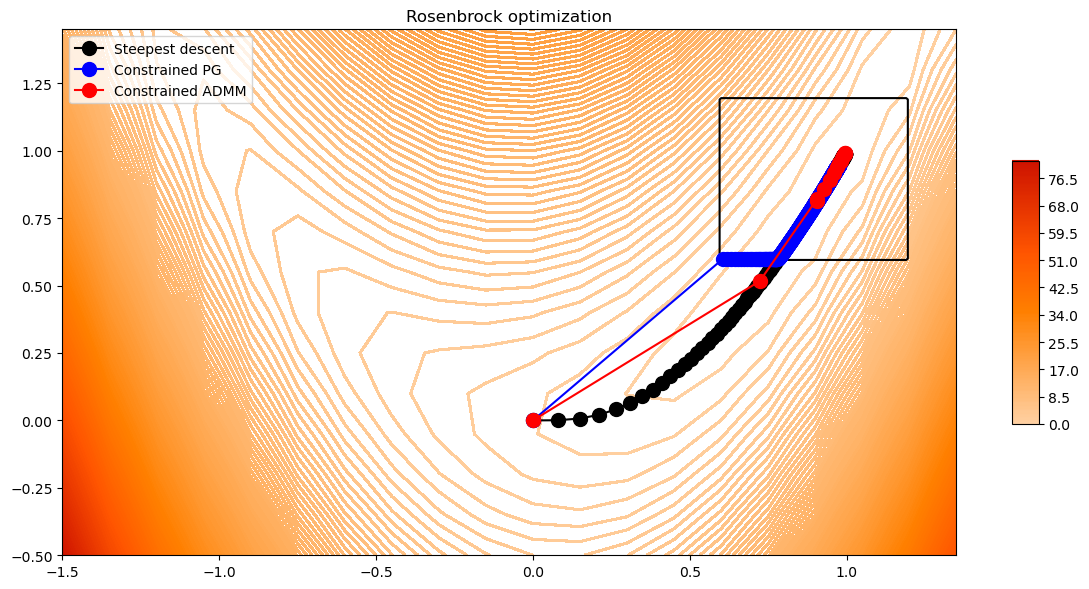

In [9]:
fig, ax = contour_rosenbrock(x, y)
ax.contour(X, Y, indic, colors='k')
ax.plot(xhist_nl[::2, 0], xhist_nl[::2, 1], '.-k', ms=20, label='Steepest descent')
ax.plot(xhist_pg[::2, 0], xhist_pg[::2, 1], '.-b', ms=20, label='Constrained PG')
ax.plot(xhist_admm[::2, 0], xhist_admm[::2, 1], '.-r', ms=20, label='Constrained ADMM')
ax.set_title('Rosenbrock optimization')
ax.legend(loc='upper left')
ax.set_xlim(x[0], x[-1])
ax.set_ylim(y[0], y[-1])
fig.tight_layout();

## Recap

In this tutorial we have learned to:

- How to solve problems with nonlinear functionals in PyProximal;
- How to include box constraints in a proximal solver.